In [1]:
%matplotlib inline

# for seaborn issue:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import zipfile

import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
import seaborn as sns

from os import listdir
from os.path import isfile, join
import io

import calendar
import time
import datetime
import math

sns.set(style='white', context='notebook', palette='deep')

In [3]:
path = '/Users/cc/project/lean/data/forex/oanda/minute/'
instrument = 'eurusd' 

In [4]:
data_files = [f for f in listdir(path + instrument) if isfile(join(path + instrument, f))]

In [5]:
headers = ['Timestamp', 'Date', 'Time', 'Bid_Open', 'Bid_High', 'Bid_Low', 'Bid_Close', '_0', 'Ask_Open', 'Ask_High', 'Ask_Low', 'Ask_Close', '_1']
trade_zone = {
    'asia': 0, 'europe': 1, 'us': 2
}
trade_zone_hour = {
    'summer': { 'asia': 2100, 'europe': 700, 'us': 1200 },
    'winter': { 'asia': 2200, 'europe': 800, 'us': 1300 }
}
day_light_saving = [
    [20130310, 20131102],
    [20140309, 20141101],
    [20150308, 20151031],
    [20160313, 20161105],
    [20170312, 20171104]
]

In [31]:
def convertToDateStr(d, pattern='%Y-%m-%d'):
#     timestamp = time.mktime(datetime.datetime.strptime(d, "%Y%m%d").timetuple())
    timestamp = toTimestamp(d, '%Y%m%d')
    return datetime.datetime.utcfromtimestamp(timestamp).strftime(pattern)

def convertToTimeStr(d, t):
#     timestamp = time.mktime(datetime.datetime.strptime(d, "%Y%m%d").timetuple())
    timestamp = toTimestamp(d, '%Y%m%d')
    timestamp += int(t/1000)
    return datetime.datetime.utcfromtimestamp(timestamp).strftime('%H:%M:%S')    

def toTimestamp(date, pattern='%Y-%m-%d'):
#     return int(time.mktime(datetime.datetime.strptime(date, pattern).timetuple()))
    return calendar.timegm(datetime.datetime.strptime(date, pattern).timetuple())

def getWeekday(date):
    return datetime.datetime.fromtimestamp(toTimestamp(date)).weekday()

def getWeekNumber(timestamp):
    day = datetime.datetime.fromtimestamp(timestamp).strftime('%d')
    return int(math.ceil(int(day)/7.0))

def getTradeZone(timestamp):
    
    date = int(datetime.datetime.utcfromtimestamp(timestamp).strftime('%Y%m%d'))
    time = int(datetime.datetime.utcfromtimestamp(timestamp).strftime('%H%M'))
    
    for start, end in day_light_saving:
        dls = 'summer' if (date >= start and date <= end) else 'winter'
#         print(date, start, date >= start)
#         print(date, end, date <= end)
        if (date < start): break

    asia, europe, us = trade_zone_hour[dls].values()

    if (time >= asia and time <= europe): return 0
    elif (time >= europe and time <= us): return 1
    elif (time >= us and time <= asia): return 2


In [32]:
# end_date = 20170701
end_date = 20130131
quote_data = pd.DataFrame(columns=headers)

for f in data_files:
    if 'zip' not in f:
        continue
    
    date = f.split('_')[0]
    
    if (int(date) > end_date): 
        break
    
    print('Reading %s for %s' % (date, instrument))
    archive = zipfile.ZipFile(path + instrument + '/' + f, 'r')
    daily_data = pd.read_csv(
        io.BytesIO(archive.read(date + '_' + instrument + '_minute_quote.csv')),
        header=None,
        names=headers[2:])
    daily_data['Date'] = convertToDateStr(date)
    daily_data['Timestamp'] = daily_data['Date'].map(lambda x: toTimestamp(x)) + (daily_data['Time']/1000)
    daily_data['Timestamp'] = daily_data['Timestamp'].astype(int)
#     daily_data['Timestamp'] = daily_data['Date'].map(lambda x: toTimestamp(x))
    daily_data['Time'] = daily_data['Time'].map(lambda x: convertToTimeStr(date, x))
    daily_data['Weekday'] = daily_data['Date'].map(lambda x: getWeekday(x))
    daily_data['Week_Number'] = daily_data['Timestamp'].map(lambda x: getWeekNumber(x))
    daily_data['Trade_Zone'] = daily_data['Timestamp'].map(lambda x: getTradeZone(x))
    daily_data = daily_data[headers]
    
    quote_data = quote_data.append(daily_data)

Reading 20121231 for eurusd
Reading 20130102 for eurusd
Reading 20130103 for eurusd
Reading 20130104 for eurusd
Reading 20130106 for eurusd
Reading 20130107 for eurusd
Reading 20130108 for eurusd
Reading 20130109 for eurusd
Reading 20130110 for eurusd
Reading 20130111 for eurusd
Reading 20130113 for eurusd
Reading 20130114 for eurusd
Reading 20130115 for eurusd
Reading 20130116 for eurusd
Reading 20130117 for eurusd
Reading 20130118 for eurusd
Reading 20130120 for eurusd
Reading 20130121 for eurusd
Reading 20130122 for eurusd
Reading 20130123 for eurusd
Reading 20130124 for eurusd
Reading 20130125 for eurusd
Reading 20130127 for eurusd
Reading 20130128 for eurusd
Reading 20130129 for eurusd
Reading 20130130 for eurusd
Reading 20130131 for eurusd


In [33]:
quote_data = quote_data.drop(['_0', '_1'], axis=1)
#quote_data = quote_data.sort_values(by=['Date', 'Time'])
#quote_data.set_index(['Date', 'Time'], inplace=True)
quote_data.head()

,Timestamp,Date,Time,Bid_Open,Bid_High,Bid_Low,Bid_Close,Ask_Open,Ask_High,Ask_Low,Ask_Close
0,1356912000,2012-12-31,00:00:00,1.32254,1.32257,1.32250,1.32254,1.32276,1.32276,1.32272,1.32276
1,1356912120,2012-12-31,00:02:00,1.32254,1.32296,1.32254,1.32296,1.32276,1.32314,1.32276,1.32314
2,1356912180,2012-12-31,00:03:00,1.32296,1.32299,1.32295,1.32295,1.32314,1.32316,1.32312,1.32312
3,1356912300,2012-12-31,00:05:00,1.32295,1.32295,1.32294,1.32295,1.32312,1.32312,1.32311,1.32311
4,1356912360,2012-12-31,00:06:00,1.32295,1.32298,1.32294,1.32297,1.32311,1.32316,1.32311,1.32316


In [10]:
quote_data.iloc[1]['Timestamp']

1356796920

In [11]:
quote_data.iloc[1]['Timestamp']

1356796920

In [12]:
#quote_data = quote_data.drop('Time')
quote_data['Open'] = (quote_data['Bid_Open'] + quote_data['Ask_Open']) / 2
quote_data['High'] = (quote_data['Bid_High'] + quote_data['Ask_High']) / 2
quote_data['Low'] = (quote_data['Bid_Low'] + quote_data['Ask_Low']) / 2
quote_data['Close'] = (quote_data['Bid_Close'] + quote_data['Ask_Close']) / 2
quote_data['Body'] = quote_data['Open'] - quote_data['Close']
quote_data['Swing'] = quote_data['High'] - quote_data['Low']
quote_data.head()

,Timestamp,Date,Time,Bid_Open,Bid_High,Bid_Low,Bid_Close,Ask_Open,Ask_High,Ask_Low,Ask_Close,Open,High,Low,Close,Body,Swing
0,1356796800,2012-12-30,16:00:00,1.32254,1.32257,1.32250,1.32254,1.32276,1.32276,1.32272,1.32276,1.322650,1.322665,1.322610,1.322650,0.000000,0.000055
1,1356796920,2012-12-30,16:02:00,1.32254,1.32296,1.32254,1.32296,1.32276,1.32314,1.32276,1.32314,1.322650,1.323050,1.322650,1.323050,-0.000400,0.000400
2,1356796980,2012-12-30,16:03:00,1.32296,1.32299,1.32295,1.32295,1.32314,1.32316,1.32312,1.32312,1.323050,1.323075,1.323035,1.323035,0.000015,0.000040
3,1356797100,2012-12-30,16:05:00,1.32295,1.32295,1.32294,1.32295,1.32312,1.32312,1.32311,1.32311,1.323035,1.323035,1.323025,1.323030,0.000005,0.000010
4,1356797160,2012-12-30,16:06:00,1.32295,1.32298,1.32294,1.32297,1.32311,1.32316,1.32311,1.32316,1.323030,1.323070,1.323025,1.323065,-0.000035,0.000045


In [14]:
quote_data['Pips_Delta_M1'] = quote_data['Close'].diff(periods=1)
quote_data['Pips_Delta_M5'] = quote_data['Close'].diff(periods=5)
quote_data['Pips_Delta_M15'] = quote_data['Close'].diff(periods=15)
quote_data['Pips_Delta_M30'] = quote_data['Close'].diff(periods=30)
quote_data['Pips_Delta_H1'] = quote_data['Close'].diff(periods=60)
quote_data['Pips_Delta_H4'] = quote_data['Close'].diff(periods=240)
quote_data['Pips_Delta_D1'] = quote_data['Close'].diff(periods=240*6)

In [15]:
quote_data.tail()

,Timestamp,Date,Time,Bid_Open,Bid_High,Bid_Low,Bid_Close,Ask_Open,Ask_High,Ask_Low,...,Close,Body,Swing,Pips_Delta_M1,Pips_Delta_M5,Pips_Delta_M15,Pips_Delta_M30,Pips_Delta_H1,Pips_Delta_H4,Pips_Delta_D1
1435,1359561300,2013-01-30,15:55:00,1.36096,1.36103,1.36068,1.36077,1.36111,1.36116,1.36084,...,1.360845,0.000190,0.000335,-0.000195,-0.000310,0.001840,0.002135,0.001885,0.003290,0.003955
1436,1359561360,2013-01-30,15:56:00,1.36075,1.36101,1.36073,1.36087,1.36090,1.36113,1.36085,...,1.360940,-0.000115,0.000280,0.000095,-0.000315,0.001915,0.002225,0.001970,0.003360,0.004030
1437,1359561420,2013-01-30,15:57:00,1.36088,1.36107,1.36087,1.36107,1.36101,1.36121,1.36101,...,1.361135,-0.000190,0.000200,0.000195,-0.000015,0.002155,0.002330,0.002330,0.003580,0.004250
1438,1359561480,2013-01-30,15:58:00,1.36106,1.36107,1.36092,1.36103,1.36121,1.36121,1.36106,...,1.361115,0.000020,0.000150,-0.000020,-0.000200,0.002020,0.002360,0.002380,0.003675,0.004285
1439,1359561540,2013-01-30,15:59:00,1.36105,1.36117,1.36086,1.36110,1.36122,1.36133,1.36101,...,1.361185,-0.000050,0.000315,0.000070,0.000145,0.002075,0.002380,0.002445,0.003725,0.004355


In [16]:
quote_data = quote_data.drop(['Bid_Open', 'Bid_High', 'Bid_Low',\
                              'Bid_Close', 'Ask_Open', 'Ask_High', 'Ask_Low', 'Ask_Close'], axis=1)

In [17]:
quote_data.tail()

,Timestamp,Date,Time,Open,High,Low,Close,Body,Swing,Pips_Delta_M1,Pips_Delta_M5,Pips_Delta_M15,Pips_Delta_M30,Pips_Delta_H1,Pips_Delta_H4,Pips_Delta_D1
1435,1359561300,2013-01-30,15:55:00,1.361035,1.361095,1.360760,1.360845,0.000190,0.000335,-0.000195,-0.000310,0.001840,0.002135,0.001885,0.003290,0.003955
1436,1359561360,2013-01-30,15:56:00,1.360825,1.361070,1.360790,1.360940,-0.000115,0.000280,0.000095,-0.000315,0.001915,0.002225,0.001970,0.003360,0.004030
1437,1359561420,2013-01-30,15:57:00,1.360945,1.361140,1.360940,1.361135,-0.000190,0.000200,0.000195,-0.000015,0.002155,0.002330,0.002330,0.003580,0.004250
1438,1359561480,2013-01-30,15:58:00,1.361135,1.361140,1.360990,1.361115,0.000020,0.000150,-0.000020,-0.000200,0.002020,0.002360,0.002380,0.003675,0.004285
1439,1359561540,2013-01-30,15:59:00,1.361135,1.361250,1.360935,1.361185,-0.000050,0.000315,0.000070,0.000145,0.002075,0.002380,0.002445,0.003725,0.004355


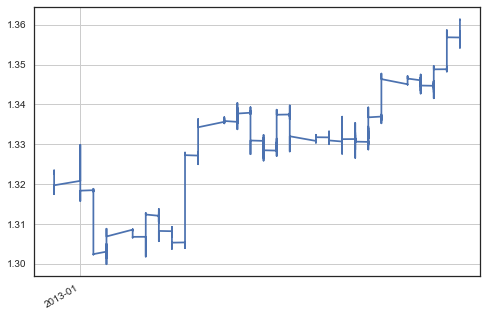

In [18]:
years = YearLocator()
months = MonthLocator()
yearsFmt = DateFormatter('%Y-%m')

fig, ax = plt.subplots()
ax.plot_date(quote_data['Date'], quote_data['Close'], '-')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.autoscale_view()


# def price(x):
#     return '$%1.2f' % x
ax.fmt_xdata = DateFormatter('%Y-%m-%d')
# ax.fmt_ydata = price

ax.grid(True)

fig.autofmt_xdate()
plt.show()

In [19]:
quote_data['SMA10'] = pd.rolling_mean(quote_data['Close'], 10)
quote_data['SMA20'] = pd.rolling_mean(quote_data['Close'], 20)
quote_data['SMA50'] = pd.rolling_mean(quote_data['Close'], 50)
quote_data['SMA100'] = pd.rolling_mean(quote_data['Close'], 100)

In [20]:
quote_data.tail()

,Timestamp,Date,Time,Open,High,Low,Close,Body,Swing,Pips_Delta_M1,Pips_Delta_M5,Pips_Delta_M15,Pips_Delta_M30,Pips_Delta_H1,Pips_Delta_H4,Pips_Delta_D1,SMA10,SMA20,SMA50,SMA100
1435,1359561300,2013-01-30,15:55:00,1.361035,1.361095,1.360760,1.360845,0.000190,0.000335,-0.000195,-0.000310,0.001840,0.002135,0.001885,0.003290,0.003955,1.360434,1.359683,1.359070,1.358669
1436,1359561360,2013-01-30,15:56:00,1.360825,1.361070,1.360790,1.360940,-0.000115,0.000280,0.000095,-0.000315,0.001915,0.002225,0.001970,0.003360,0.004030,1.360605,1.359796,1.359116,1.358699
1437,1359561420,2013-01-30,15:57:00,1.360945,1.361140,1.360940,1.361135,-0.000190,0.000200,0.000195,-0.000015,0.002155,0.002330,0.002330,0.003580,0.004250,1.360785,1.359920,1.359167,1.358731
1438,1359561480,2013-01-30,15:58:00,1.361135,1.361140,1.360990,1.361115,0.000020,0.000150,-0.000020,-0.000200,0.002020,0.002360,0.002380,0.003675,0.004285,1.360961,1.360038,1.359219,1.358761
1439,1359561540,2013-01-30,15:59:00,1.361135,1.361250,1.360935,1.361185,-0.000050,0.000315,0.000070,0.000145,0.002075,0.002380,0.002445,0.003725,0.004355,1.361114,1.360156,1.359271,1.358792


In [21]:
quote_data['EMA10'] = quote_data['Close'].ewm(span=10, min_periods=10, adjust=False).mean()
quote_data['EMA20'] = quote_data['Close'].ewm(span=20, min_periods=20, adjust=False).mean()
quote_data['EMA50'] = quote_data['Close'].ewm(span=50, min_periods=50, adjust=False).mean()
quote_data['EMA100'] = quote_data['Close'].ewm(span=100, min_periods=100, adjust=False).mean()

In [22]:
def RSI(df, period=14):
 
    delta = df.diff()
    up, down = delta.copy(), delta.copy()

    up[up < 0] = 0
    down[down > 0] = 0

    rUp = up.ewm(com=period - 1,  adjust=False).mean()
    rDown = down.ewm(com=period - 1, adjust=False).mean().abs()

    rsi = 100 - 100 / (1 + rUp / rDown)    
    rsi = rsi.to_frame('RSI')
    rsi.iloc[:period] = 0
    return rsi

In [23]:
quote_data['RSI14'] = RSI(quote_data['Close'])

In [24]:
#quote_data = quote_data.drop(['High', 'Low', 'Open', 'Close'], axis=1)

In [25]:
quote_data.tail()

,Timestamp,Date,Time,Open,High,Low,Close,Body,Swing,Pips_Delta_M1,...,Pips_Delta_D1,SMA10,SMA20,SMA50,SMA100,EMA10,EMA20,EMA50,EMA100,RSI14
1435,1359561300,2013-01-30,15:55:00,1.361035,1.361095,1.360760,1.360845,0.000190,0.000335,-0.000195,...,0.003955,1.360434,1.359683,1.359070,1.358669,1.360530,1.359978,1.359296,1.358848,74.170224
1436,1359561360,2013-01-30,15:56:00,1.360825,1.361070,1.360790,1.360940,-0.000115,0.000280,0.000095,...,0.004030,1.360605,1.359796,1.359116,1.358699,1.360605,1.360070,1.359361,1.358890,75.201129
1437,1359561420,2013-01-30,15:57:00,1.360945,1.361140,1.360940,1.361135,-0.000190,0.000200,0.000195,...,0.004250,1.360785,1.359920,1.359167,1.358731,1.360701,1.360171,1.359430,1.358934,77.211642
1438,1359561480,2013-01-30,15:58:00,1.361135,1.361140,1.360990,1.361115,0.000020,0.000150,-0.000020,...,0.004285,1.360961,1.360038,1.359219,1.358761,1.360776,1.360261,1.359496,1.358977,76.526365
1439,1359561540,2013-01-30,15:59:00,1.361135,1.361250,1.360935,1.361185,-0.000050,0.000315,0.000070,...,0.004355,1.361114,1.360156,1.359271,1.358792,1.360851,1.360349,1.359562,1.359021,77.286211


In [208]:
quote_data.to_csv('./data/quote.csv', index=False)

### Remark

    Add Timezone
    Add weekday
    Multiply pips by 1000 to save memory

In [2]:
df = pd.read_csv('./data/quote_M5.csv')

In [3]:
df.shape

(178270, 883)

In [13]:
spread = df[df.columns[1]]

In [14]:
spread.describe()

count    178270.000000
mean          1.568110
std           0.814239
min           0.700000
25%           1.300000
50%           1.400000
75%           1.600000
max          20.000000
Name: 1.300000, dtype: float64

In [16]:
spread = spread[spread < 5]

In [18]:
pd.qcut(spread, 4)

0         (0.699, 1.3]
1         (0.699, 1.3]
2         (0.699, 1.3]
3           (1.4, 1.6]
4           (1.4, 1.6]
5         (0.699, 1.3]
6           (1.3, 1.4]
7           (1.3, 1.4]
8           (1.3, 1.4]
9         (0.699, 1.3]
10        (0.699, 1.3]
11        (0.699, 1.3]
12        (0.699, 1.3]
13          (1.3, 1.4]
14        (0.699, 1.3]
15        (0.699, 1.3]
16        (0.699, 1.3]
17          (1.3, 1.4]
18          (1.3, 1.4]
19        (0.699, 1.3]
20        (0.699, 1.3]
21          (1.3, 1.4]
22        (0.699, 1.3]
23        (0.699, 1.3]
24          (1.3, 1.4]
25          (1.3, 1.4]
26        (0.699, 1.3]
27        (0.699, 1.3]
28        (0.699, 1.3]
29          (1.3, 1.4]
              ...     
178239    (0.699, 1.3]
178240    (0.699, 1.3]
178241    (0.699, 1.3]
178242    (0.699, 1.3]
178243    (0.699, 1.3]
178244    (0.699, 1.3]
178245    (0.699, 1.3]
178246    (0.699, 1.3]
178247    (0.699, 1.3]
178248    (0.699, 1.3]
178249    (0.699, 1.3]
178250    (0.699, 1.3]
178251     

In [19]:
span = df[df.columns[2]]

In [20]:
span.describe()

count    178270.000000
mean          4.941653
std           4.492263
min           0.000000
25%           2.400000
50%           3.900000
75%           6.100000
max         216.600000
Name: 1.900000, dtype: float64

In [22]:
pd.qcut(span[span < 20], 4)

0         (-0.001, 2.4]
1          (6.0, 19.95]
2           (3.85, 6.0]
3           (3.85, 6.0]
4         (-0.001, 2.4]
5         (-0.001, 2.4]
6           (3.85, 6.0]
7         (-0.001, 2.4]
8         (-0.001, 2.4]
9         (-0.001, 2.4]
10        (-0.001, 2.4]
11          (3.85, 6.0]
12          (2.4, 3.85]
13          (2.4, 3.85]
14          (3.85, 6.0]
15          (2.4, 3.85]
16        (-0.001, 2.4]
17          (2.4, 3.85]
18        (-0.001, 2.4]
19        (-0.001, 2.4]
20          (3.85, 6.0]
21         (6.0, 19.95]
22          (3.85, 6.0]
23         (6.0, 19.95]
24         (6.0, 19.95]
25          (3.85, 6.0]
26          (3.85, 6.0]
27          (3.85, 6.0]
28          (2.4, 3.85]
29          (3.85, 6.0]
              ...      
178240      (2.4, 3.85]
178241    (-0.001, 2.4]
178242      (2.4, 3.85]
178243    (-0.001, 2.4]
178244      (3.85, 6.0]
178245      (2.4, 3.85]
178246     (6.0, 19.95]
178247      (2.4, 3.85]
178248    (-0.001, 2.4]
178249    (-0.001, 2.4]
178250    (-0.00